<a href="https://colab.research.google.com/github/EliHarper/TensorflowKerasMachineLearning/blob/master/ProcessingSequencesUsingRNNs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
    IS_COLAB = True
except Exception:
    IS_COLAB = False

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

if not tf.test.is_gpu_available():
    print("No GPU was detected. LSTMs and CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "rnn"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

TensorFlow 2.x selected.
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
No GPU was detected. LSTMs and CNNs can be very slow without a GPU.
Go to Runtime > Change runtime and select a GPU hardware accelerator.


In [0]:
def generate_time_series(batch_size, n_steps):
  freq1, freq2, offsets1, offsets2 = np.random.rand(4, batch_size, 1)
  time = np.linspace(0, 1, n_steps)
  series = 0.5 * np.sin((time - offsets1) * (freq1 * 10 + 10))  # wave 1
  series += 0.2 * np.sin((time - offsets2) * (freq2 * 20 + 20)) # + wave 2
  series += 0.1 * (np.random.rand(batch_size, n_steps) - 0.5)   # + noise
  return series[..., np.newaxis].astype(np.float32)

In [0]:
np.random.seed(42)

n_steps = 50
series = generate_time_series(10000, n_steps + 1)
X_train, y_train = series[:7000, :n_steps], series[:7000, -1]
X_valid, y_valid = series[7000:9000, :n_steps], series[7000:9000, -1]
X_test, y_test = series[9000:, :n_steps], series[9000:, -1]

In [0]:
X_train.shape, y_train.shape

((7000, 50, 1), (7000, 1))

Saving figure time_series_plot


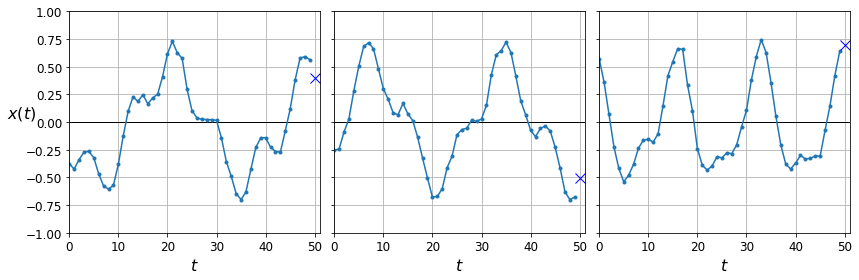

In [0]:
def plot_series(series, y=None, y_pred=None, x_label="$t$", y_label="$x(t)$"):
  plt.plot(series, ".-")
  if y is not None:
    plt.plot(n_steps, y, "bx", markersize=10)
  if y_pred is not None:
    plt.plot(n_steps, y_pred, "ro")
  plt.grid(True)
  if x_label:
    plt.xlabel(x_label, fontsize=16)
  if y_label:
    plt.ylabel(y_label, fontsize=16, rotation=0)
  plt.hlines(0, 0, 100, linewidth=1)
  plt.axis([0, n_steps + 1, -1, 1])

fig, axes = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(12, 4))
for col in range(3):
  plt.sca(axes[col])
  plot_series(X_valid[col, :, 0], y_valid[col, 0],
              y_label=("$x(t)$" if col==0 else None))

save_fig("time_series_plot")
plt.show()

In [0]:
# Now let's compute some baselines:

y_pred = X_valid[:, -1] # predict the 1st y value by taking the entirety of the X validation set and guessing the -1 index (last), a "naive" prediction
np.mean(keras.losses.mean_squared_error(y_valid, y_pred))

0.020211367

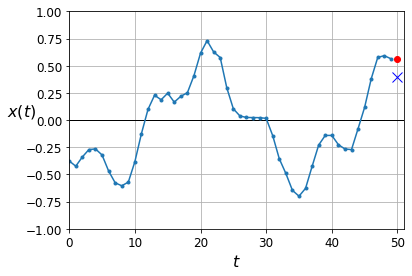

In [0]:
plot_series(X_valid[0, :, 0], y_valid[0,0], y_pred[0,0])
plt.show() # MSE didn't look that bad, but IMO, that point looks like a pretty bad prediction

In [0]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
                                 keras.layers.Flatten(input_shape=[50, 1]),
                                 keras.layers.Dense(1)
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

Train on 7000 samples, validate on 2000 samples
Epoch 1/20
7000/7000 [==============================] - 1s 134us/sample - loss: 0.1004 - val_loss: 0.0559
Epoch 2/20
7000/7000 [==============================] - 0s 57us/sample - loss: 0.0386 - val_loss: 0.0269
Epoch 3/20
7000/7000 [==============================] - 0s 56us/sample - loss: 0.0205 - val_loss: 0.0162
Epoch 4/20
7000/7000 [==============================] - 0s 53us/sample - loss: 0.0133 - val_loss: 0.0118
Epoch 5/20
7000/7000 [==============================] - 0s 53us/sample - loss: 0.0104 - val_loss: 0.0098
Epoch 6/20
7000/7000 [==============================] - 0s 53us/sample - loss: 0.0089 - val_loss: 0.0087
Epoch 7/20
7000/7000 [==============================] - 0s 53us/sample - loss: 0.0080 - val_loss: 0.0078
Epoch 8/20
7000/7000 [==============================] - 0s 55us/sample - loss: 0.0073 - val_loss: 0.0071
Epoch 9/20
7000/7000 [==============================] - 0s 51us/sample - loss: 0.0066 - val_loss: 0.0065
Epoch 

In [0]:
model.evaluate(X_valid, y_valid)

2000/2000 [==============================] - 0s 35us/sample - loss: 0.0041


0.004145486276596785

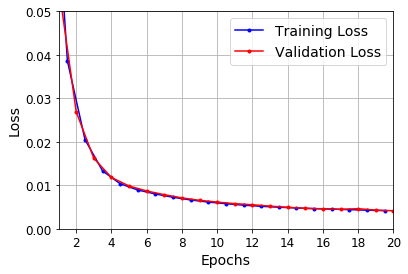

In [0]:
def plot_learning_curves(loss, val_loss):
  plt.plot(np.arange(len(loss)) + 0.5, loss, "b.-", label="Training Loss")
  plt.plot(np.arange(len(val_loss)) + 1,val_loss, "r.-", label="Validation Loss")
  plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
  plt.axis([1, 20, 0, 0.05])
  plt.legend(fontsize=14)
  plt.xlabel("Epochs")
  plt.ylabel("Loss")
  plt.grid(True)

plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

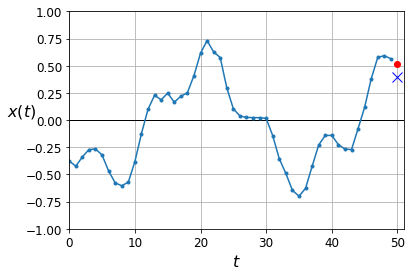

In [0]:
y_pred = model.predict(X_valid)
plot_series(X_valid[0, :, 0], y_valid[0,0], y_pred[0,0])
plt.show() # Looks much better than the naive prediction

In [0]:
# Using a (very) simple RNN
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
  keras.layers.SimpleRNN(1, input_shape=[None,1])
])

optimizer = keras.optimizers.Adam(lr=0.005)
model.compile(loss="mse", optimizer=optimizer)
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

Train on 7000 samples, validate on 2000 samples
Epoch 1/20
7000/7000 [==============================] - 3s 465us/sample - loss: 0.0972 - val_loss: 0.0491
Epoch 2/20
7000/7000 [==============================] - 2s 329us/sample - loss: 0.0372 - val_loss: 0.0298
Epoch 3/20
7000/7000 [==============================] - 2s 330us/sample - loss: 0.0255 - val_loss: 0.0220
Epoch 4/20
7000/7000 [==============================] - 2s 319us/sample - loss: 0.0200 - val_loss: 0.0178
Epoch 5/20
7000/7000 [==============================] - 2s 325us/sample - loss: 0.0167 - val_loss: 0.0152
Epoch 6/20
7000/7000 [==============================] - 2s 325us/sample - loss: 0.0147 - val_loss: 0.0135
Epoch 7/20
7000/7000 [==============================] - 2s 324us/sample - loss: 0.0133 - val_loss: 0.0124
Epoch 8/20
7000/7000 [==============================] - 2s 329us/sample - loss: 0.0124 - val_loss: 0.0117
Epoch 9/20
7000/7000 [==============================] - 2s 331us/sample - loss: 0.0119 - val_loss: 0.011

In [0]:
model.evaluate(X_valid, y_valid)

2000/2000 [==============================] - 0s 85us/sample - loss: 0.0109


0.010885455533862115

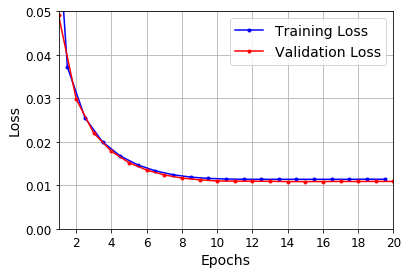

In [0]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

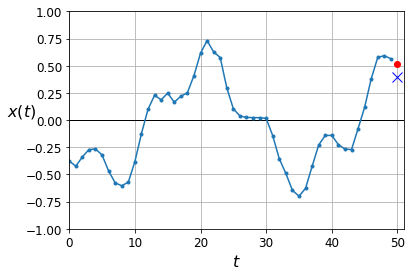

In [0]:
y_pred = model.predict(X_valid)
plot_series(X_valid[0, :, 0], y_valid[0,0], y_pred[0,0])
plt.show() # Meh:

In [0]:
# Could probably be improved by making a Deep RNN by stacking multiple SimpleRNN layers:

np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
                                 keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),  # Input
                                 keras.layers.SimpleRNN(20, return_sequences=True),                         # Hidden
                                 keras.layers.SimpleRNN(1)                                                  # Output
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

Train on 7000 samples, validate on 2000 samples
Epoch 1/20
7000/7000 [==============================] - 9s 1ms/sample - loss: 0.0433 - val_loss: 0.0073
Epoch 2/20
7000/7000 [==============================] - 7s 1ms/sample - loss: 0.0066 - val_loss: 0.0052
Epoch 3/20
7000/7000 [==============================] - 7s 999us/sample - loss: 0.0051 - val_loss: 0.0043
Epoch 4/20
7000/7000 [==============================] - 7s 1ms/sample - loss: 0.0045 - val_loss: 0.0044
Epoch 5/20
7000/7000 [==============================] - 7s 1ms/sample - loss: 0.0040 - val_loss: 0.0038
Epoch 6/20
7000/7000 [==============================] - 7s 1ms/sample - loss: 0.0038 - val_loss: 0.0042
Epoch 7/20
7000/7000 [==============================] - 7s 1ms/sample - loss: 0.0037 - val_loss: 0.0033
Epoch 8/20
7000/7000 [==============================] - 7s 1ms/sample - loss: 0.0036 - val_loss: 0.0035
Epoch 9/20
7000/7000 [==============================] - 7s 982us/sample - loss: 0.0034 - val_loss: 0.0038
Epoch 10/20


In [0]:
model.evaluate(X_valid, y_valid)

2000/2000 [==============================] - 1s 257us/sample - loss: 0.0029


0.0029341068509966136

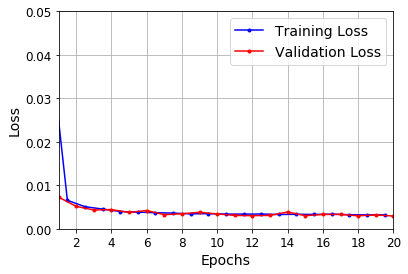

In [0]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

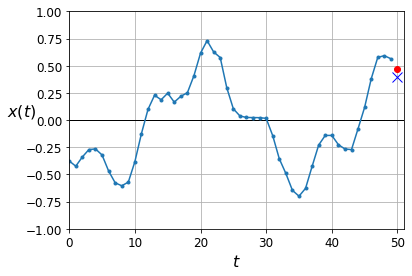

In [0]:
y_pred = model.predict(X_valid)
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

In [0]:
np.random.seed(42)
tf.random.set_seed(42)

# Make this RNN return only the last output:

model = keras.models.Sequential([
                                 keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None,1]),
                                 keras.layers.SimpleRNN(20),
                                 keras.layers.Dense(1)
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, y_train, epochs=20,
                    validation_data = (X_valid, y_valid))

Train on 7000 samples, validate on 2000 samples
Epoch 1/20
7000/7000 [==============================] - 7s 930us/sample - loss: 0.0221 - val_loss: 0.0053
Epoch 2/20
7000/7000 [==============================] - 5s 719us/sample - loss: 0.0043 - val_loss: 0.0037
Epoch 3/20
7000/7000 [==============================] - 5s 727us/sample - loss: 0.0035 - val_loss: 0.0032
Epoch 4/20
7000/7000 [==============================] - 5s 722us/sample - loss: 0.0033 - val_loss: 0.0032
Epoch 5/20
7000/7000 [==============================] - 5s 696us/sample - loss: 0.0032 - val_loss: 0.0030
Epoch 6/20
7000/7000 [==============================] - 5s 700us/sample - loss: 0.0031 - val_loss: 0.0030
Epoch 7/20
7000/7000 [==============================] - 5s 687us/sample - loss: 0.0031 - val_loss: 0.0028
Epoch 8/20
7000/7000 [==============================] - 5s 655us/sample - loss: 0.0031 - val_loss: 0.0028
Epoch 9/20
7000/7000 [==============================] - 5s 701us/sample - loss: 0.0030 - val_loss: 0.002

In [0]:
model.evaluate(X_valid, y_valid)

2000/2000 [==============================] - 0s 182us/sample - loss: 0.0026


0.0025768047142773866

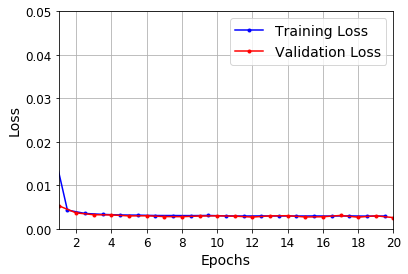

In [0]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])

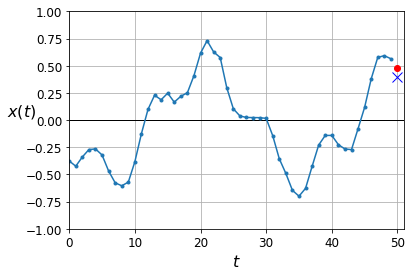

In [0]:
y_pred = model.predict(X_valid)
plot_series(X_valid[0, :, 0], y_valid[0,0], y_pred[0,0])
plt.show()

In [0]:
# Forecasting several steps ahead

np.random.seed(43) # Not 42, as it would give the first series in the training set

series = generate_time_series(1, n_steps + 10)
X_new, Y_new = series[:, :n_steps], series[:, n_steps:]
X = X_new
for step_ahead in range(10):
  y_pred_one = model.predict(X[:, step_ahead:])[:, np.newaxis, :]
  X = np.concatenate([X, y_pred_one], axis=1)

Y_pred = X[:, n_steps:]

In [0]:
Y_pred.shape

(1, 10, 1)

Saving figure forecast_ahead_plot


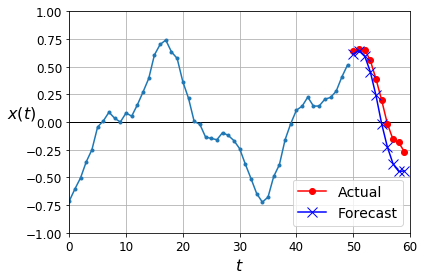

In [0]:
def plot_multiple_forecasts(X, Y, Y_pred):
  n_steps = X.shape[1]
  ahead = Y.shape[1]
  plot_series(X[0, :, 0])
  plt.plot(np.arange(n_steps, n_steps + ahead), Y[0, :, 0], "ro-", label="Actual")
  plt.plot(np.arange(n_steps, n_steps + ahead), Y_pred[0, :, 0], "bx-", label="Forecast", markersize=10)
  plt.axis([0, n_steps + ahead, -1, 1])
  plt.legend(fontsize=14)

plot_multiple_forecasts(X_new, Y_new, Y_pred)
save_fig("forecast_ahead_plot")
plt.show()

In [0]:
# Now let's use the model to predict the next 10 values.
#   Generate the sequences with 9 more time steps:

np.random.seed(42)

n_steps = 50
series = generate_time_series(10000, n_steps + 10)
X_train, Y_train = series[:7000, :n_steps], series[:7000, -10:, 0]
X_valid, Y_valid = series[7000:9000, :n_steps], series[7000:9000, -10:, 0]
X_test, Y_test = series[9000:, :n_steps], series[9000:, -10:, 0]

In [0]:
X = X_valid
for step_ahead in range(10):
  y_pred_one = model.predict(X)[:, np.newaxis, :]
  X = np.concatenate([X, y_pred_one], axis=1)

Y_pred = X[:, n_steps:, 0]

In [0]:
Y_pred.shape

(2000, 10)

In [0]:
np.mean(keras.metrics.mean_squared_error(Y_valid, Y_pred))

0.027277306

In [0]:
Y_naive_pred = Y_valid[:, -1:]
np.mean(keras.metrics.mean_squared_error(Y_valid, Y_naive_pred))

0.22278848

In [0]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
                                 keras.layers.Flatten(input_shape=[50, 1]),
                                 keras.layers.Dense(10)
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Train on 7000 samples, validate on 2000 samples
Epoch 1/20
7000/7000 [==============================] - 1s 104us/sample - loss: 0.1348 - val_loss: 0.0610
Epoch 2/20
7000/7000 [==============================] - 0s 65us/sample - loss: 0.0501 - val_loss: 0.0427
Epoch 3/20
7000/7000 [==============================] - 0s 59us/sample - loss: 0.0388 - val_loss: 0.0356
Epoch 4/20
7000/7000 [==============================] - 0s 57us/sample - loss: 0.0334 - val_loss: 0.0314
Epoch 5/20
7000/7000 [==============================] - 0s 65us/sample - loss: 0.0299 - val_loss: 0.0286
Epoch 6/20
7000/7000 [==============================] - 0s 61us/sample - loss: 0.0275 - val_loss: 0.0264
Epoch 7/20
7000/7000 [==============================] - 0s 59us/sample - loss: 0.0258 - val_loss: 0.0251
Epoch 8/20
7000/7000 [==============================] - 0s 60us/sample - loss: 0.0245 - val_loss: 0.0237
Epoch 9/20
7000/7000 [==============================] - 0s 57us/sample - loss: 0.0235 - val_loss: 0.0229
Epoch 

In [0]:
# Now to create an RNN that predicts all of the next 10 values at once:

np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
                                 keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
                                 keras.layers.SimpleRNN(20),
                                 keras.layers.Dense(10)
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Train on 7000 samples, validate on 2000 samples
Epoch 1/20
7000/7000 [==============================] - 6s 877us/sample - loss: 0.0665 - val_loss: 0.0317
Epoch 2/20
7000/7000 [==============================] - 5s 721us/sample - loss: 0.0268 - val_loss: 0.0221
Epoch 3/20
7000/7000 [==============================] - 5s 730us/sample - loss: 0.0188 - val_loss: 0.0166
Epoch 4/20
7000/7000 [==============================] - 5s 730us/sample - loss: 0.0159 - val_loss: 0.0137
Epoch 5/20
7000/7000 [==============================] - 5s 701us/sample - loss: 0.0138 - val_loss: 0.0127
Epoch 6/20
7000/7000 [==============================] - 5s 697us/sample - loss: 0.0132 - val_loss: 0.0117
Epoch 7/20
7000/7000 [==============================] - 5s 694us/sample - loss: 0.0119 - val_loss: 0.0117
Epoch 8/20
7000/7000 [==============================] - 5s 703us/sample - loss: 0.0115 - val_loss: 0.0119
Epoch 9/20
7000/7000 [==============================] - 5s 691us/sample - loss: 0.0110 - val_loss: 0.011

In [0]:
np.random.seed(43)

series = generate_time_series(1, 50 + 10)
X_new, Y_new = series[:, :50, :], series[:, -10:, :]
Y_pred = model.predict(X_new)[..., np.newaxis]

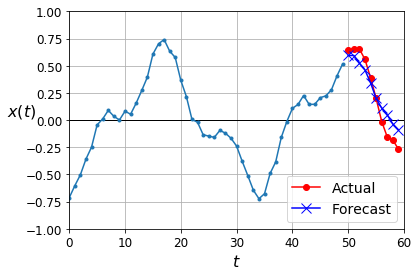

In [0]:
plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()

In [0]:
# Now to create an RNN that predicts the next 10 at each time step

np.random.seed(42)

n_steps = 50
series = generate_time_series(10000, n_steps + 10)
X_train = series[:7000, :n_steps]
X_valid = series[7000:9000, :n_steps]
X_teset = series[9000:, :n_steps]

Y = np.empty((10000, n_steps, 10))
for step_ahead in range(1, 10 + 1):
  Y[..., step_ahead - 1] = series[..., step_ahead:step_ahead + n_steps, 0]

Y_train = Y[:7000]
Y_valid = Y[7000:9000]
Y_test = Y[9000:]

In [0]:
X_train.shape, Y_train.shape

((7000, 50, 1), (7000, 50, 10))

In [0]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
                                 keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
                                 keras.layers.SimpleRNN(20, return_sequences=True),
                                 keras.layers.TimeDistributed(keras.layers.Dense(10))
])

def last_time_step_mse(Y_true, Y_pred):
  return keras.metrics.mean_squared_error(Y_true[:, -1], Y_pred[:, -1])

model.compile(loss="mse", optimizer=keras.optimizers.Adam(lr=0.01), metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Train on 7000 samples, validate on 2000 samples
Epoch 1/20
7000/7000 [==============================] - 6s 893us/sample - loss: 0.0498 - last_time_step_mse: 0.0388 - val_loss: 0.0416 - val_last_time_step_mse: 0.0321
Epoch 2/20
7000/7000 [==============================] - 5s 732us/sample - loss: 0.0389 - last_time_step_mse: 0.0282 - val_loss: 0.0336 - val_last_time_step_mse: 0.0236
Epoch 3/20
7000/7000 [==============================] - 5s 732us/sample - loss: 0.0329 - last_time_step_mse: 0.0219 - val_loss: 0.0328 - val_last_time_step_mse: 0.0231
Epoch 4/20
7000/7000 [==============================] - 5s 715us/sample - loss: 0.0294 - last_time_step_mse: 0.0181 - val_loss: 0.0279 - val_last_time_step_mse: 0.0166
Epoch 5/20
7000/7000 [==============================] - 5s 734us/sample - loss: 0.0272 - last_time_step_mse: 0.0153 - val_loss: 0.0270 - val_last_time_step_mse: 0.0158
Epoch 6/20
7000/7000 [==============================] - 5s 713us/sample - loss: 0.0247 - last_time_step_mse: 0.0

In [0]:
np.random.seed(43)

series = generate_time_series(1, 50 + 10)
X_new, Y_new = series[:, :50, :], series[:, 50:, :]
Y_pred = model.predict(X_new)[:, -1][..., np.newaxis]

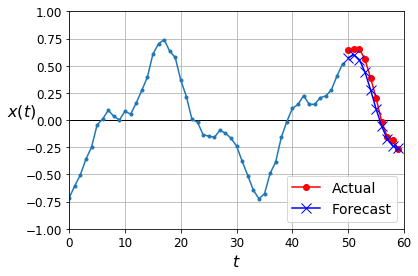

In [0]:
plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()

In [0]:
# Deep RNN with Batch Norm:

np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
                                 keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
                                 keras.layers.BatchNormalization(),
                                 keras.layers.SimpleRNN(20, return_sequences=True),
                                 keras.layers.BatchNormalization(),
                                 keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid)) # Underwhelming MSE

Train on 7000 samples, validate on 2000 samples
Epoch 1/20
7000/7000 [==============================] - 8s 1ms/sample - loss: 0.1936 - last_time_step_mse: 0.1913 - val_loss: 0.0901 - val_last_time_step_mse: 0.0863
Epoch 2/20
7000/7000 [==============================] - 6s 819us/sample - loss: 0.0531 - last_time_step_mse: 0.0441 - val_loss: 0.0559 - val_last_time_step_mse: 0.0469
Epoch 3/20
7000/7000 [==============================] - 5s 753us/sample - loss: 0.0470 - last_time_step_mse: 0.0374 - val_loss: 0.0453 - val_last_time_step_mse: 0.0354
Epoch 4/20
7000/7000 [==============================] - 5s 760us/sample - loss: 0.0437 - last_time_step_mse: 0.0337 - val_loss: 0.0423 - val_last_time_step_mse: 0.0320
Epoch 5/20
7000/7000 [==============================] - 5s 777us/sample - loss: 0.0414 - last_time_step_mse: 0.0310 - val_loss: 0.0402 - val_last_time_step_mse: 0.0301
Epoch 6/20
7000/7000 [==============================] - 5s 783us/sample - loss: 0.0390 - last_time_step_mse: 0.028

In [0]:
from tensorflow.keras.layers import LayerNormalization

In [0]:
class LNSimpleRNNCell(keras.layers.Layer):
    def __init__(self, units, activation="tanh", **kwargs):
        super().__init__(**kwargs)
        self.state_size = units
        self.output_size = units
        self.simple_rnn_cell = keras.layers.SimpleRNNCell(units,
                                                          activation=None)
        self.layer_norm = LayerNormalization()
        self.activation = keras.activations.get(activation)
    def get_initial_state(self, inputs=None, batch_size=None, dtype=None):
        if inputs is not None:
            batch_size = tf.shape(inputs)[0]
            dtype = inputs.dtype
        return [tf.zeros([batch_size, self.state_size], dtype=dtype)]
    def call(self, inputs, states):
        outputs, new_states = self.simple_rnn_cell(inputs, states)
        norm_outputs = self.activation(self.layer_norm(outputs))
        return norm_outputs, [norm_outputs]

In [0]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
                                 keras.layers.RNN(LNSimpleRNNCell(20), return_sequences=True,
                                                  input_shape=[None, 1]),
                                 keras.layers.RNN(LNSimpleRNNCell(20), return_sequences=True),
                                 keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Train on 7000 samples, validate on 2000 samples
Epoch 1/20
7000/7000 [==============================] - 12s 2ms/sample - loss: 0.1563 - last_time_step_mse: 0.1502 - val_loss: 0.0712 - val_last_time_step_mse: 0.0657
Epoch 2/20
7000/7000 [==============================] - 10s 1ms/sample - loss: 0.0629 - last_time_step_mse: 0.0561 - val_loss: 0.0565 - val_last_time_step_mse: 0.0495
Epoch 3/20
7000/7000 [==============================] - 10s 1ms/sample - loss: 0.0539 - last_time_step_mse: 0.0466 - val_loss: 0.0505 - val_last_time_step_mse: 0.0434
Epoch 4/20
7000/7000 [==============================] - 10s 1ms/sample - loss: 0.0494 - last_time_step_mse: 0.0420 - val_loss: 0.0469 - val_last_time_step_mse: 0.0397
Epoch 5/20
7000/7000 [==============================] - 9s 1ms/sample - loss: 0.0450 - last_time_step_mse: 0.0370 - val_loss: 0.0409 - val_last_time_step_mse: 0.0315
Epoch 6/20
7000/7000 [==============================] - 10s 1ms/sample - loss: 0.0393 - last_time_step_mse: 0.0289 - v

In [0]:
# Creating a Custom RNN Class:

class MyRNN(keras.layers.Layer):
  def __init__(self, cell, return_sequences=False, **kwargs):
    super().__init__(**kwargs)
    self.cell = cell
    self.return_sequences = return_sequences
    self.get_initial_state = getattr(
        self.cell, "get_initial_state", self.fallback_initial_state)
  
  def fallback_initial_state(self, inputs):
    return [tf.zeros([self.cell.state_size], dtype = inputs.dtype)]

  @tf.function
  def call(self, inputs):
    states = self.get_initial_state(inputs)
    n_steps = tf.shape(inputs)[1]
    if self.return_sequences:
      sequences = tf.TensorArray(inputs.dtype, size=n_steps)
    outputs = tf.zeros(shape=[n_steps, self.cell.output_size], dtype=inputs.dtype)
    for step in tf.range(n_steps):
      outputs, states = self.cell(inputs[:, step], states)
      if self.return_sequences:
        sequences = sequences.write(step, outputs)
    if self.return_sequences:
      return sequences.stack()
    else:
      return outputs

In [0]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
                                 MyRNN(LNSimpleRNNCell(20), return_sequences=True,
                                       input_shape=[None, 1]),
                                 MyRNN(LNSimpleRNNCell(20), return_sequences=True),
                                 keras.layers.TimeDistributed(keras.layers.Dense(10))                                 
])

model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=10,
                    validation_data=(X_valid, Y_valid))

Train on 7000 samples, validate on 2000 samples
Epoch 1/10
7000/7000 [==============================] - 11s 2ms/sample - loss: 0.2185 - last_time_step_mse: 0.2075 - val_loss: 0.0877 - val_last_time_step_mse: 0.0771
Epoch 2/10
7000/7000 [==============================] - 9s 1ms/sample - loss: 0.0721 - last_time_step_mse: 0.0597 - val_loss: 0.0620 - val_last_time_step_mse: 0.0487
Epoch 3/10
7000/7000 [==============================] - 9s 1ms/sample - loss: 0.0567 - last_time_step_mse: 0.0423 - val_loss: 0.0525 - val_last_time_step_mse: 0.0381
Epoch 4/10
7000/7000 [==============================] - 9s 1ms/sample - loss: 0.0498 - last_time_step_mse: 0.0351 - val_loss: 0.0476 - val_last_time_step_mse: 0.0319
Epoch 5/10
7000/7000 [==============================] - 9s 1ms/sample - loss: 0.0455 - last_time_step_mse: 0.0310 - val_loss: 0.0438 - val_last_time_step_mse: 0.0294
Epoch 6/10
7000/7000 [==============================] - 9s 1ms/sample - loss: 0.0425 - last_time_step_mse: 0.0284 - val_l

In [0]:
# LSTMs!!!!!!!!!!!!!!!!

np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.LSTM(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.LSTM(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Train on 7000 samples, validate on 2000 samples
Epoch 1/20
7000/7000 [==============================] - 12s 2ms/sample - loss: 0.0760 - last_time_step_mse: 0.0615 - val_loss: 0.0554 - val_last_time_step_mse: 0.0372
Epoch 2/20
7000/7000 [==============================] - 9s 1ms/sample - loss: 0.0480 - last_time_step_mse: 0.0281 - val_loss: 0.0423 - val_last_time_step_mse: 0.0211
Epoch 3/20
7000/7000 [==============================] - 9s 1ms/sample - loss: 0.0390 - last_time_step_mse: 0.0182 - val_loss: 0.0371 - val_last_time_step_mse: 0.0164
Epoch 4/20
7000/7000 [==============================] - 9s 1ms/sample - loss: 0.0350 - last_time_step_mse: 0.0151 - val_loss: 0.0335 - val_last_time_step_mse: 0.0143
Epoch 5/20
7000/7000 [==============================] - 9s 1ms/sample - loss: 0.0325 - last_time_step_mse: 0.0136 - val_loss: 0.0314 - val_last_time_step_mse: 0.0124
Epoch 6/20
7000/7000 [==============================] - 9s 1ms/sample - loss: 0.0308 - last_time_step_mse: 0.0123 - val_l

In [0]:
model.evaluate(X_valid, Y_valid)

2000/2000 [==============================] - 1s 327us/sample - loss: 0.0240 - last_time_step_mse: 0.0086


[0.024016652926802634, 0.008551411]

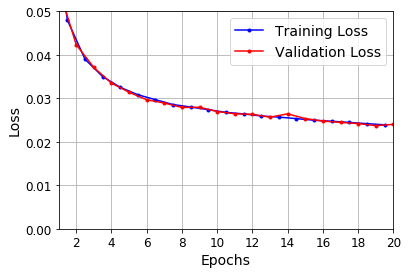

In [0]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

In [0]:
np.random.seed(43)

series = generate_time_series(1, 50 + 10)
X_new, Y_new = series[:, :50, :], series[:, 50:, :]
Y_pred = model.predict(X_new)[:, -1][..., np.newaxis]

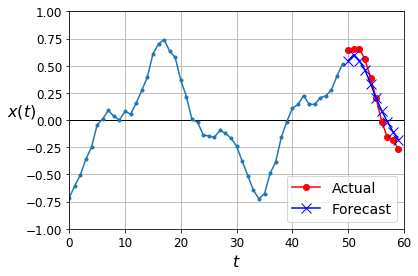

In [0]:
plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()

In [0]:
# GRUs
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
                                 keras.layers.GRU(20, return_sequences=True, input_shape=[None, 1]),
                                 keras.layers.GRU(20, return_sequences=True),
                                 keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Train on 7000 samples, validate on 2000 samples
Epoch 1/20
7000/7000 [==============================] - 14s 2ms/sample - loss: 0.0742 - last_time_step_mse: 0.0663 - val_loss: 0.0523 - val_last_time_step_mse: 0.0421
Epoch 2/20
7000/7000 [==============================] - 10s 1ms/sample - loss: 0.0476 - last_time_step_mse: 0.0367 - val_loss: 0.0441 - val_last_time_step_mse: 0.0327
Epoch 3/20
7000/7000 [==============================] - 11s 2ms/sample - loss: 0.0418 - last_time_step_mse: 0.0305 - val_loss: 0.0391 - val_last_time_step_mse: 0.0271
Epoch 4/20
7000/7000 [==============================] - 11s 2ms/sample - loss: 0.0373 - last_time_step_mse: 0.0249 - val_loss: 0.0343 - val_last_time_step_mse: 0.0205
Epoch 5/20
7000/7000 [==============================] - 10s 1ms/sample - loss: 0.0327 - last_time_step_mse: 0.0179 - val_loss: 0.0313 - val_last_time_step_mse: 0.0158
Epoch 6/20
7000/7000 [==============================] - 11s 2ms/sample - loss: 0.0308 - last_time_step_mse: 0.0155 - 

In [0]:
model.evaluate(X_valid, Y_valid)

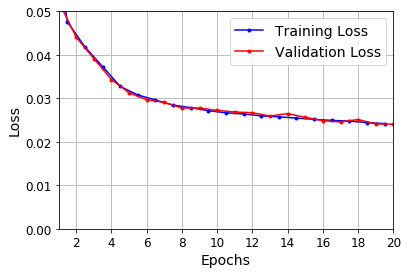

In [0]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

In [0]:
np.random.seed(43)

series = generate_time_series(1, 50 + 10)
X_new, Y_new = series[:, :50, :], series[:, 50:, :]
Y_pred = model.predict(X_new)[:, -1][..., np.newaxis]

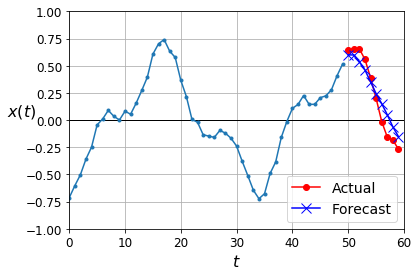

In [0]:
plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()

In [0]:
# Using One-Dimensional Convolutional Layers to Process Sequences:
#   This puts forward some pretty incredible mse values.. .0067? Good god.

np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
                                 keras.layers.Conv1D(filters=20, kernel_size = 4, strides=2, padding="valid",
                                                     input_shape=[None,1]),
                                 keras.layers.GRU(20, return_sequences=True),
                                 keras.layers.GRU(20, return_sequences=True),
                                 keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train[:, 3::2], epochs=20,
                    validation_data=(X_valid, Y_valid[:, 3::2])) # Important: don't forget to trim the training and validation Y_* data; lengths must be equal and with valid padding, they won't be to begin with.

Train on 7000 samples, validate on 2000 samples
Epoch 1/20
7000/7000 [==============================] - 9s 1ms/sample - loss: 0.0683 - last_time_step_mse: 0.0605 - val_loss: 0.0482 - val_last_time_step_mse: 0.0405
Epoch 2/20
7000/7000 [==============================] - 6s 867us/sample - loss: 0.0416 - last_time_step_mse: 0.0342 - val_loss: 0.0368 - val_last_time_step_mse: 0.0283
Epoch 3/20
7000/7000 [==============================] - 6s 850us/sample - loss: 0.0334 - last_time_step_mse: 0.0251 - val_loss: 0.0307 - val_last_time_step_mse: 0.0220
Epoch 4/20
7000/7000 [==============================] - 6s 826us/sample - loss: 0.0273 - last_time_step_mse: 0.0172 - val_loss: 0.0251 - val_last_time_step_mse: 0.0141
Epoch 5/20
7000/7000 [==============================] - 6s 847us/sample - loss: 0.0243 - last_time_step_mse: 0.0134 - val_loss: 0.0238 - val_last_time_step_mse: 0.0128
Epoch 6/20
7000/7000 [==============================] - 6s 873us/sample - loss: 0.0230 - last_time_step_mse: 0.012

In [0]:
# WaveNet

np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential()
model.add(keras.layers.InputLayer(input_shape=[None, 1]))
for rate in (1, 2, 4, 8) * 2:
  model.add(keras.layers.Conv1D(filters=20, kernel_size=2, padding="causal",
                                activation="relu", dilation_rate=rate))
model.add(keras.layers.Conv1D(filters=10, kernel_size=1))
model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history= model.fit(X_train, Y_train, epochs=20,
                   validation_data=(X_valid, Y_valid))

Train on 7000 samples, validate on 2000 samples
Epoch 1/20
7000/7000 [==============================] - 5s 710us/sample - loss: 0.0684 - last_time_step_mse: 0.0550 - val_loss: 0.0387 - val_last_time_step_mse: 0.0248
Epoch 2/20
7000/7000 [==============================] - 4s 555us/sample - loss: 0.0342 - last_time_step_mse: 0.0216 - val_loss: 0.0307 - val_last_time_step_mse: 0.0182
Epoch 3/20
7000/7000 [==============================] - 4s 545us/sample - loss: 0.0293 - last_time_step_mse: 0.0172 - val_loss: 0.0275 - val_last_time_step_mse: 0.0152
Epoch 4/20
7000/7000 [==============================] - 4s 550us/sample - loss: 0.0270 - last_time_step_mse: 0.0149 - val_loss: 0.0259 - val_last_time_step_mse: 0.0140
Epoch 5/20
7000/7000 [==============================] - 4s 564us/sample - loss: 0.0254 - last_time_step_mse: 0.0134 - val_loss: 0.0247 - val_last_time_step_mse: 0.0126
Epoch 6/20
7000/7000 [==============================] - 4s 571us/sample - loss: 0.0245 - last_time_step_mse: 0.0